# Approximating Steel Cased Wells - DC, layered background

[Lindsey Heagy](http://github.com/lheagy)

In this example, we examine the impact of upscaling the well using
- the assumption that the well is a solid rod of steel
- averaging conductivity such that the $\sigma A$ is the same in both cases

The background is a layered earth model

This notebook was used to produce Figures 24, 25

In [1]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot
import ipywidgets
from string import ascii_lowercase

from SimPEG.EM import TDEM
from SimPEG import Utils, Maps

import casingSimulations as casingSim

from pymatsolver import Pardiso

%matplotlib inline

##  Parameters

In [2]:
simDir = 'DC_approximations_geologic_noise'  # create a simulation directory where results can be saved. 

In [3]:
casing_l = 2000
sigma_back = 1e-1

In [4]:
casing_t = 10e-3 # 10mm thick casing
casing_d = 100e-3 # 10cm diameter

model = casingSim.model.CasingInLayers(
    directory = simDir,
    sigma_casing = 5e6,  # conductivity of the casing (S/m)
    sigma_back = sigma_back,  # conductivity of the background (S/m)
    sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
    sigma_air = 3e-7,   # conductivity of the air
    casing_d = casing_d-casing_t,  # 135mm is outer casing diameter
    casing_l = casing_l,
    casing_t = casing_t, 
    src_a = np.r_[0., np.pi, -1.25],  # put the A electrode just below the surface
    src_b = np.r_[8000, np.pi, -1.25] # put the return electrode at a distance of 2 x length of well away
)

# adjust the src_a location so it is connected to well
model.src_a = np.r_[model.casing_r, np.pi, -1.25]  


In [5]:
model_dict = {
    "casing": model
}

## Mesh

Here we set up a 3D cylindrical mesh, discretizing in $x$, $\theta$ and $z$. 

To discretize in x, we start by defining the finest region of the mesh, ensuring that we have 4 cells across the thickness of the casing. From there, we expand the cell sizes until we reach the second uniform cell size we want to model at (`csx2`). We then use a constant cell spacing of `csx2` until we have meshed out to the end of the domain in which we want to examine data (`domainx2`). Beyond that, we add padding cells to *"infinity"*

In [6]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 20.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 500  # go out 500m from the well

# padding parameters
npadx, npadz = 16, 20  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4

# discretization in theta
ncy = 1
# ncy = 12
# nstretchy = 5
# stretchfact = 1.5
# hy = utils.meshTensor([(1, nstretchy, -stretchfact), (1, ncy), (1, nstretchy, stretchfact)])
hy = np.ones(ncy)
hy = hy * 2*np.pi/hy.sum()

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry


cylMeshGen = casingSim.CasingMeshGenerator(
    directory=simDir,  # directory where we can save things
    modelParameters=model,  # casing parameters
    npadx=npadx,  # number of padding cells in the x-direction
    npadz=npadz,  # number of padding cells in the z-direction
    domain_x=domainx2,  # extent of the second uniform region of the mesh 
    hy=hy,   # cell spacings in the 
    csx1=model.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
    csx2=csx2,  # second core cell size
    csz=csz,  # cell size in the z-direction
    pfx2=pfx2,  # padding factor to "infinity"
    pfz=pfz  # padding factor to "infinity" for the z-direction
)

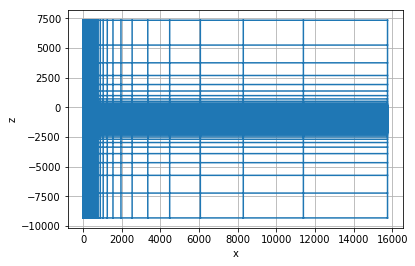

In [7]:
cylMeshGen.mesh.plotGrid()

### Create layered background

In [8]:
def random_layers(magnitude_perturbation=1, layer_t=50, seed=3):
    np.random.seed(seed=seed)
    nlayers = int(2*casing_l / layer_t) + 1
    perturbation = np.random.randn(nlayers)

    log_sigma_layers = (perturbation - perturbation.mean()) / perturbation.sum() * magnitude_perturbation
    log_sigma_layers = log_sigma_layers + np.log(sigma_back)
    sigma_layers = np.exp(log_sigma_layers)
    sigma_layers = sigma_layers * sigma_back / sigma_layers.mean()

    return sigma_layers

In [9]:
layer_t = 50
nlayers = int(2*casing_l / layer_t) + 1
layer_tops = layer_t * np.ones(nlayers - 1)
layer_tops = list(-np.cumsum(np.hstack([[0], layer_tops])))

In [10]:
model.layer_tops = layer_tops

In [11]:
model_dict = {}
seeds = [0, 1, 2]
for s, m in zip(seeds, [10, 20, 30]):
    sigma_layers = random_layers(layer_t=layer_t, seed=s, magnitude_perturbation=m)
    tmp = model.copy()
    tmp.sigma_layers = list(sigma_layers)
    model_dict.update(
        {"casing_{}".format(s): tmp}
    )

## Create models to compare to

Here, we create two more models which we want to simulate on
- `solid` fills in the center of the casing with a conductivity equal to that of steel
- `sigma_A` approximates the casing as a solid rod with conductivity found by preserving the conductivity - cross sectional area product. 

In [12]:
# Solid steel
def get_cylinder_model(model, option='solid'):
    model_solid = model.copy()
    model_solid.casing_d = casing_d / 2.
    model_solid.casing_t = casing_d / 2.
    model_solid.sigma_inside = model_solid.sigma_casing  # fill in the center of the well with steel
    
    if option == 'sigma_A':
        sigmaA = model.sigma_casing * (model.casing_b**2 - model.casing_a**2) / (model.casing_b**2)  # times pi / pi
        model_solid.sigma_inside = sigmaA
        model_solid.sigma_casing = sigmaA
    return model_solid

In [13]:
for m in ["solid", "sigma_A"]:
    model_dict.update(
        {"{}_{}".format(m, s): get_cylinder_model(model_dict["casing_{}".format(s)], m) for s in seeds}
    )


In [14]:
model_names = ["{}".format(key) for key in model_dict.keys()]
print(model_names)

['casing_0', 'casing_1', 'casing_2', 'solid_0', 'solid_1', 'solid_2', 'sigma_A_0', 'sigma_A_1', 'sigma_A_2']


In [15]:
# Assign physical properties on the mesh
physprops_dict = {
    key: casingSim.model.PhysicalProperties(cylMeshGen, model_dict[key]) for key in model_names
}

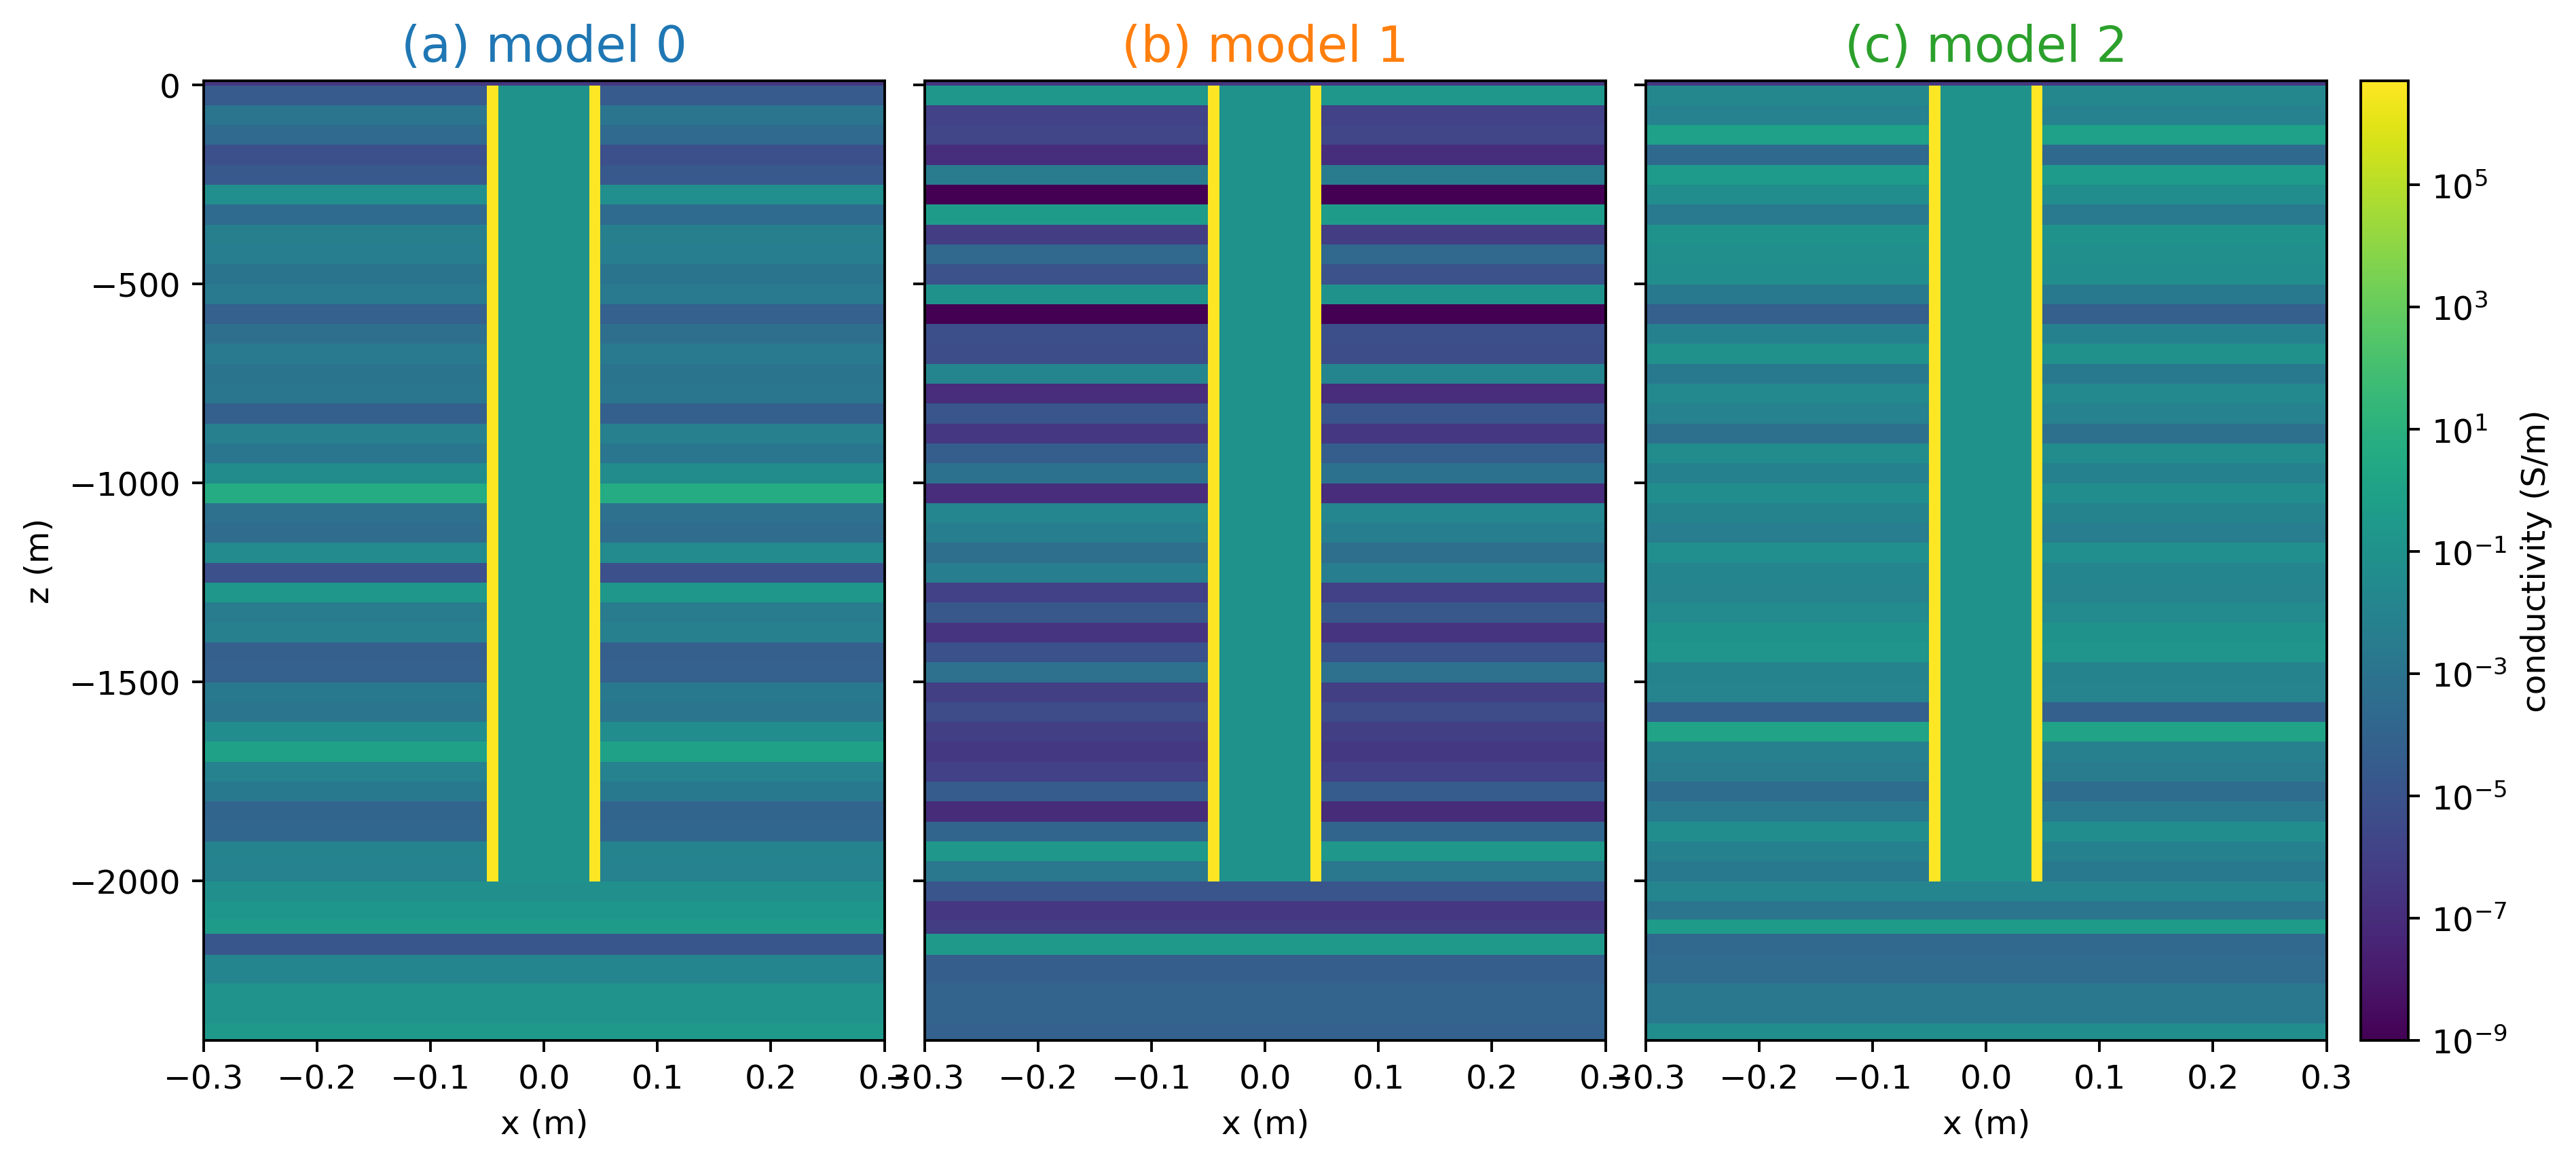

In [16]:
# Plot the models
xlim = 0.3*np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.2*casing_l, 10.]  # z-limits in meters. (z-positive up)


fig, ax = plt.subplots(1, 3, figsize=(10, 5), dpi=350)
fig.subplots_adjust(right=0.8)

for s, a in zip(seeds, ax):
    key = "casing_{}".format(s)
    pp = physprops_dict[key]
    out = pp.plot_sigma(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}, # plot on a log-scale
        clim = [1e-9, 5e6], 
        show_cb = False
    )
    a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m'.format(key, pp.modelParameters.sigma_casing), fontsize=13)
#     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)
    a.set_title("({}) model {}".format(ascii_lowercase[s], s), color="C{}".format(s), fontsize=15)
    a.set_xlabel("x (m)")
    
    if s > 0:
        a.set_yticklabels(['']*len(a.get_yticklabels()))
        a.set_ylabel('')
        
plt.tight_layout()
ax_position = ax[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0 + ax_position.width*1.05, ax_position.y0, 0.02, ax_position.height])
cb = plt.colorbar(out[0], cbar_ax, orientation='vertical')
cb.set_label('conductivity (S/m)')
ax[0].set_ylabel('z (m)')

fig.savefig("../figures/random_layers", dpi=350, bbox_inches="tight")

### set up source location

In [17]:
src_a = np.r_[model_dict[model_names[0]].casing_r, np.pi, -1.25]
src_b = np.r_[8000, np.pi, -1.25]

## set up a DC simulation

In [18]:
sim_dict = {}
for key in model_names:
#     print(mesh_dict[key.split("_")[-1]])
    sim_dict[key] = casingSim.run.SimulationDC(
        modelParameters=model_dict[key], directory=simDir, 
        meshGenerator=cylMeshGen, 
        src_a=src_a, src_b=src_b
    )


Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.


In [19]:
%%time
fields_dict = {}
for key in model_names:
    print('--- Running {} ---'.format(key))
    fields_dict[key] = sim_dict[key].run()
    print('\n')

--- Running casing_0 ---
Validating parameters...
      max x: 15755.673364665585, min z: -9324.722349712412, max z: 7324.722349712405, nC: 82450
Saved DC_approximations_geologic_noise/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 0.6323752403259277


--- Running casing_1 ---
Validating parameters...
      max x: 15755.673364665585, min z: -9324.722349712412, max z: 7324.722349712405, nC: 82450
Saved DC_approximations_geologic_noise/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 0.4668571949005127


--- Running casing_2 ---
Validating parameters...
      max x: 15755.673364665585, min z: -9324.722349712412, max z: 7324.722349712405, nC: 82450
Saved DC_approximations_geologic_noise/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 0.39574193954467773


---

## Plot Results

Here we plot the radial electric field along a line $90^{\circ}$ from the source. 

In [20]:
# src_ind=0

# def plot_results(ax=None):
#     """
#     Plot the currents and charges along the length of the casing. If `include_transmission`
#     is True, then the transmission line solutions from Kaufmann (described in the functions 
#     above) are included
#     """
   
#     if ax is None: 
#         fig, ax = plt.subplots(1, 2, figsize=(10, 4)) #, dpi=400)
    
#     for i, key in enumerate(model_names):
#         f = fields_dict[key]
#         src = sim_dict[key].survey.srcList[src_ind]
#         mod = model_dict[key]
#         mesh = mesh_dict[key.split("_")[-1]].mesh
    
#         z_currents, iz = casingSim.casing_currents(f[src, 'j'], mesh, mod)["z"]
#         z_charges, charges = casingSim.casing_charges(f[src, 'charge'], mesh, mod)
        
        
        
#         label = key.split("_")[-1] + " m"
        
#         ax[0, 0].plot(-z_currents/mod.casing_l, -iz, label=label, color="C{}".format(i))
#         ax[1, 0].plot(-z_charges/mod.casing_l, charges, label=label, color="C{}".format(i))
        
#         casingSim.view.plotLinesFx(
#             mesh, field=f[src,'e'],
#             pltType='semilogy', ax=ax[2, 0],
#             theta_ind=theta_ind, xlim=xlim, 
#             color_ind=i, label=key, 
#             zloc=zloc
#         )
        

#     [a.set_xlim([1.25/mod.casing_l, 1.]) for a in ax]
#     [a.legend() for a in ax]
#     [a.set_xlabel('depth / casing length') for a in ax]
#     [a.grid(which='both', alpha=0.4) for a in ax]

#     ax[0].set_ylabel('downward-going current (A)')
#     ax[1].set_ylabel('charge (C)')
    
#     return ax

In [21]:
def get_surface_efield(key, zloc=0, src_ind=0, xlim=np.r_[0, np.inf]):
    mesh2D = mesh_dict[key.split("_")[-1]].mesh
    src = sim_dict[key].survey.srcList[src_ind]
    fplt = fields_dict[key][src, 'e']

    fx = discretize.utils.mkvc(fplt[:mesh2D.vnF[0]].reshape(
        [mesh2D.vnFx[0], mesh2D.vnFx[2]], order='F')
    )
    xind = ((mesh2D.gridFx[:, 0] > xlim[0]) & (mesh2D.gridFx[:, 0] < xlim[1]))
    zind = (
        (mesh2D.gridFx[:, 2] > -mesh2D.hz.min()+zloc) & (mesh2D.gridFx[:, 2] < zloc)
    )
    pltind = xind & zind
    
    x = mesh2D.gridFx[pltind, 0]
    e = fx[pltind]
    
    return x, e

In [22]:
import matplotlib.lines as mlines
from string import ascii_lowercase 
from matplotlib import rcParams
rcParams['font.size'] = 12

In [23]:
for s in seeds:
    m = model_dict["casing_{}".format(s)]
    print("{} {:1.2e} {:1.2e}".format(s, np.mean(m.sigma_layers), np.std(np.log10(m.sigma_layers))))

0 1.00e-01 1.21e+00
1 1.00e-01 2.21e+00
2 1.00e-01 9.57e-01


sigma_A_0: 7.28e-06, 2.95e-18
sigma_A_1: 5.00e-06, 3.57e-18
sigma_A_2: 1.07e-06, 4.70e-19


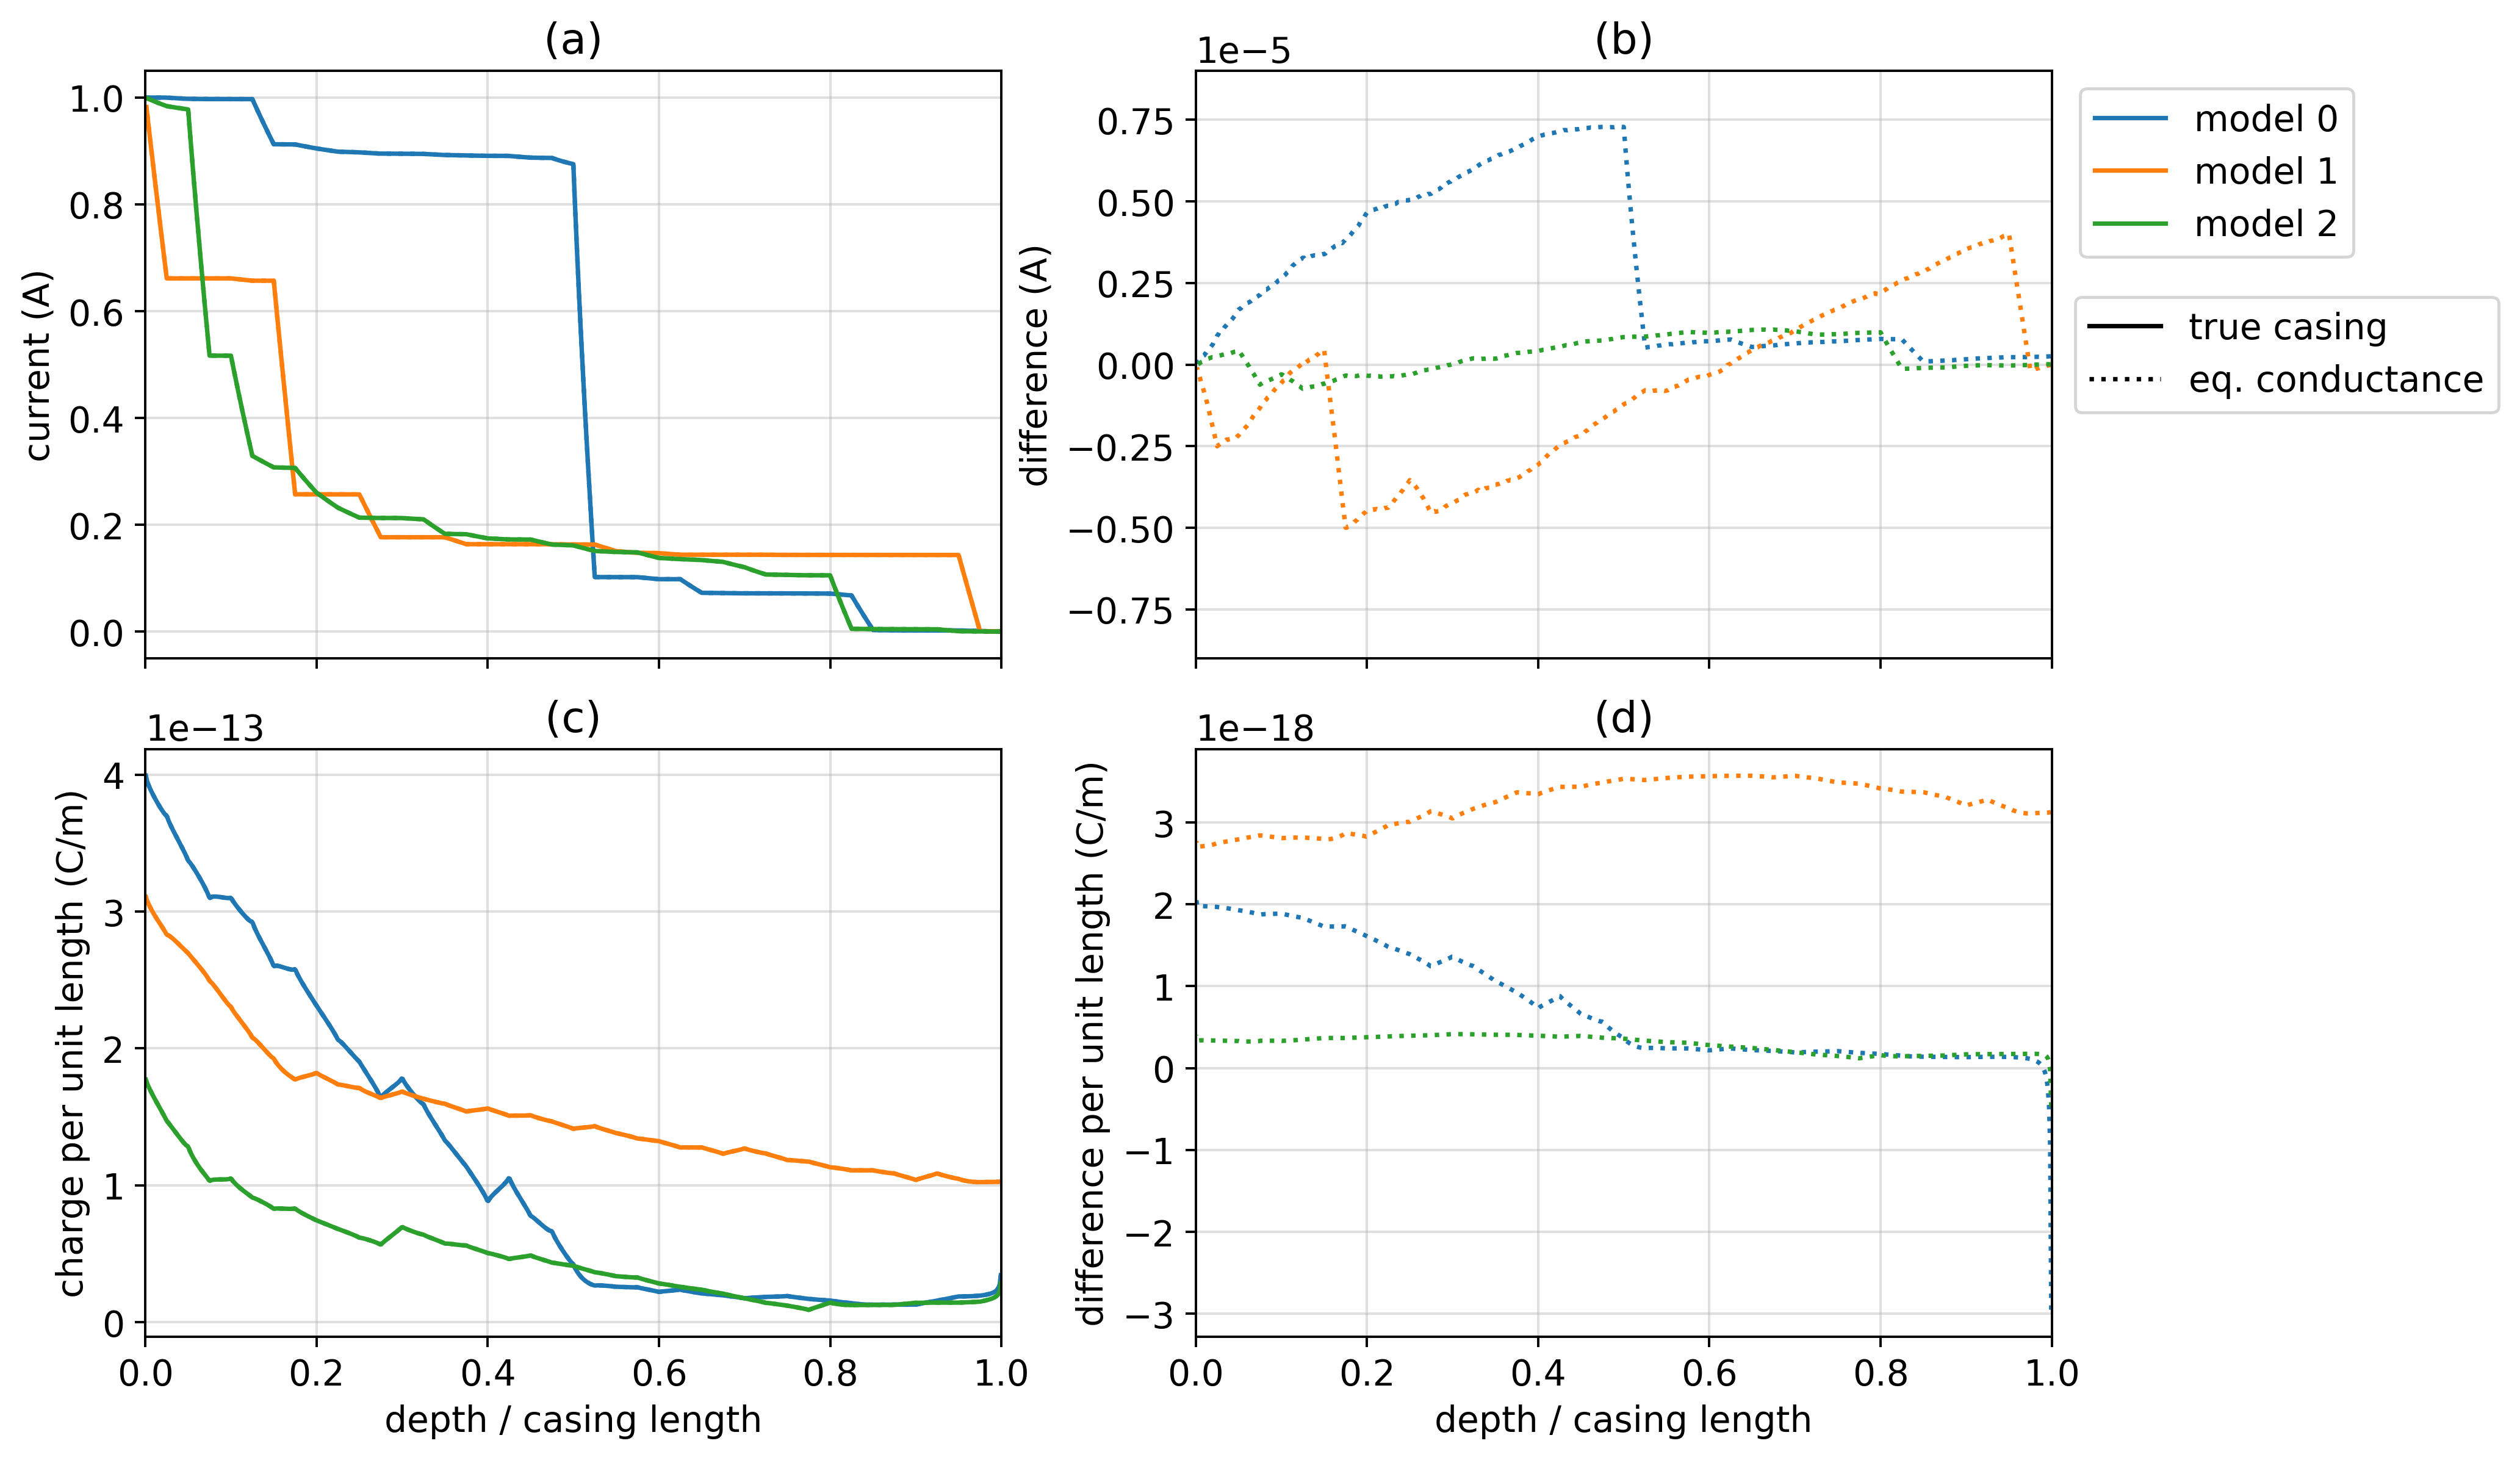

In [25]:
fig, ax  =  plt.subplots(2, 2, figsize=(10, 7), dpi=350)

# for i, l in enumerate(casing_l[:-1]):
src_ind = 0
mesh = cylMeshGen.mesh


for i, s in enumerate(seeds):
    casing_key = "casing_{}".format(s)
    src = sim_dict[casing_key].survey.srcList[src_ind]
    _, iz_casing = casingSim.casing_currents(
        fields_dict[casing_key][src, 'j'], mesh, model_dict[casing_key]
    )["z"]
    _, charges_casing = casingSim.casing_charges(
        fields_dict[casing_key][src, 'charge'], mesh, model_dict[casing_key]
    )

    for model_key, ls in zip(["casing", "sigma_A"], ["-", ":"]):
        key = "{}_{}".format(model_key, i)
        f = fields_dict[key]
        src = sim_dict[key].survey.srcList[src_ind]
        mod = model_dict[key]

        z_currents, iz = casingSim.casing_currents(f[src, 'j'], mesh, mod)["z"]
        z_charges, charges = casingSim.casing_charges(f[src, 'charge'], mesh, mod)

        label = "model " + key.split("_")[-1]

        ax[0, 0].plot(
            -z_currents/mod.casing_l, -iz, label=label if ls == "-" else None, color="C{}".format(i), 
            ls=ls
        )
        ax[1, 0].plot(-z_charges/mod.casing_l, charges / csz, color="C{}".format(i), ls=ls)

        if model_key != "casing":
            diff_i = (iz - iz_casing)
            diff_charges = (charges - charges_casing) / csz
            print("{}: {:1.2e}, {:1.2e}".format(key, np.absolute(diff_i).max(), np.absolute(diff_charges).max()))

            ax[0, 1].plot(
                -z_currents/mod.casing_l, -(diff_i), label=label if ls == "-" else None, color="C{}".format(i), 
                ls=ls
            )
            ax[1, 1].plot(-z_charges/mod.casing_l, diff_charges, color="C{}".format(i), ls=ls)

#             ax[0, 2].plot(
#                 -z_currents/mod.casing_l, -(iz - iz_casing) / np.abs(iz_casing) * 100, label=label if ls == "-" else None, color="C{}".format(i), 
#                 ls=ls
#             )
#         ax[1, 2].plot(-z_charges/mod.casing_l, (charges - charges_casing) / np.abs(charges_casing) * 100, color="C{}".format(i), ls=ls)
        

[a.set_xlim([0., 1.]) for a in ax.flatten()]
# [a.legend() for a in ax]
# [a.set_xlabel('depth / casing length') for a in ax]
[a.grid(which='both', alpha=0.4) for a in ax.flatten()]
# [a.ticklabel_format(scilimits=)]

ax[0, 0].set_ylabel('current (A)')
ax[0, 1].set_ylabel('difference (A)')
# ax[0, 2].set_ylabel('difference (%)')

ax[1, 0].set_ylabel('charge per unit length (C/m)')
ax[1, 1].set_ylabel('difference per unit length (C/m)')
# ax[1, 2].set_ylabel('difference (%)')

for a in ax[0, :]:
    a.set_xticklabels(['']*len(a.get_xticklabels()))
    a.set_xlabel('')

for a in ax[1, :]:
    a.set_xlabel("depth / casing length")
    
ax[0, 0].legend(bbox_to_anchor=[2.6, 1])

ax[1, 0].legend(
    handles=[
        mlines.Line2D([], [], color='k', label='true casing'),
#         mlines.Line2D([], [], color='k', linestyle='--', label='solid steel'), 
        mlines.Line2D([], [], color='k', linestyle=':', label='eq. conductance')
    ], bbox_to_anchor=[2.77, 1.8]
)

[a.set_title("({})".format(ascii_lowercase[i])) for i, a in enumerate(ax.flatten())]
ax[0, 1].set_ylim(9e-6*np.r_[-1, 1])
ax[0, 1].ticklabel_format(axis='y', scilimits=(0, 0))
# ax[1, 1].set_ylim(2.5e-18*np.r_[-1, 1])

# ax[0].set_ylabel('downward-going current (A)')
# ax[1].set_ylabel('charge (C)')

# ax[1].set_ylim(8e-12*np.r_[0, 1])
# # [a.set_xlim([-mod.src_a[2]/mod.casing_l, 1.]) for a in ax]

# ax[0].set_title('(a)')
# ax[1].set_title('(b)')

plt.tight_layout()

fig.savefig("../figures/approximating_wells_currents_charges_random", bbox_inches="tight", dpi=350)